In [23]:
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import colors as clr
import numpy as np
import sys
import re
import fileinput
import scipy as scp

# function to change OUTPUT file into space-separated float fields and parameterise the data using this new format
# line in 'with open' bit is type 'str'

# create a function to get spectral grid data
bound_inds = []
oldstr = ['0-','1-','2-','3-','4-','5-','6-','7-','8-','9-']
newstr = ['0 -','1 -','2 -','3 -','4 -','5 -','6 -','7 -','8 -','9 -']

def data_read_gaia(f):
    missed_line_inds = []
    temp_data = []
    temp_rad_zone_data = []
    check = 0
    #number of lines to cut = number of line containing 'convective shell' label - (2 + any additional string lines)
    for line in f:
        for i in range(len(oldstr)):
            line = line.replace(oldstr[i],newstr[i])
        check = check + 1
        for x in range(4,1,-1):
            line = line.replace((x*' '),' ')
        line = line.replace('D','E')
        match_ast = re.search('[**]', line)
        match_inf = re.search('Infinity',line)
        if match_ast or match_inf or (line.strip()==''):
            missed_line_inds.append(check)
            #continue
        else:
            file_data = np.array([float(parameter) for parameter in line.strip().split(' ')])
            temp_data.append(file_data)
    out_all_data = np.array(temp_data)

    print 'Total dataset: ',out_all_data.shape
    return out_all_data

# select the parameter (Teff or log(g) for each array(file)) with which to analyse the filter profiles,
# by setting the other to be constant, using the column number (integer)
def grid_vals_dict(input_arr,col_numb):
    col_vals = []
    col_var_arrs = {}
    # create list of values of the column NOT being examined
    for i in range(len(input_arr[:,(col_numb - 1)])):
        if (input_arr[i,(col_numb - 1)] not in col_vals):
            col_vals.append(input_arr[i,(col_numb - 1)])
    print 'Table column',col_numb,'values list: ',col_vals
    # create arrays for fixed values of col_numb parameter
    # by
    for j in col_vals:
        temp_k_list = []
        for k in range(len(input_arr[:,(col_numb - 1)])):
            if (input_arr[k,(col_numb - 1)] == j):
                temp_k_list.append(input_arr[k,:])
        temp_k_array = np.array(temp_k_list)
        print 'For column',col_numb,'value of',j,', the array has the following shape: ',temp_k_array.shape
        col_var_arrs[str(j)] = temp_k_array
    print 'Final dictionary length: ',len(col_var_arrs)
    return col_var_arrs, col_vals

# To do for plots:
# X, Y axes labels
# 

# Function to plot multiple Teff or log(g) lines (for 1 filter output ONLY!)
# Input: dictionary of relevant arrays, pyplot axes name (text),fixed input variable values (list of strings)
def dict_2D_plot(input_dict,ax,col_x,col_y,var_names,col_map):
    label_int = 6
    if (col_x == 1):
        label_int = 1
    elif (col_x == 2):
        label_int = 0
        
    plt.gca().set_color_cycle([col_map(j) for j in np.linspace(0.9, 0, len(input_dict))])
    # grid_vals_dict gives the fixed value as the key for the array
    for i in reversed(sorted(input_dict.iterkeys())):
        ax.plot((input_dict[i])[:,(col_x-1)],(input_dict[i])[:,(col_y-1)],label=(var_names[label_int]+'='+i))
    ax.set_xlabel(var_names[(col_x-1)])
    ax.set_ylabel(var_names[(col_y-1)])
    plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.1))
    ax.set_title('Stuff',y=1.05)
    plt.show()
    
def diff_grid_dict(dict_Av0,dict_Avne0):
    diff_dict = {}
    
    # use sets to match keys in dictionaries
    combined_set = set(dict_Av0).intersection(set(dict_Avne0))
    for key_val in combined_set:
        print key_val
        # use variables to store each key value
        Av0_arr_kv = dict_Av0[key_val]
        Avne0_arr_kv = dict_Avne0[key_val]
        # take the difference of the two sets of filter magnitudes for different calibrations of BCs
        # gives absolute extinction A(X) as numerical output
        diff_arr_kv = Av0_arr_kv - Avne0_arr_kv
        for n in range(len(diff_arr_kv[0,:])):
            if (n == 0 or n == 1):
                # these columns are Teff, log(g) - the inputs for the grid - need to reset these to recover grid
                diff_arr_kv[:,n] = Av0_arr_kv[:,n]
        diff_dict[key_val] = diff_arr_kv
        if (diff_arr_kv.shape != Avne0_arr_kv.shape):
            print 'shape error'
    print 'Raw A(X) dictionary complete'
    return diff_dict
    
#def plot_polynomial_fit()

print 'modules loaded & functions compiled'

modules loaded & functions compiled


In [24]:
# N.B.: usiing cgs unit
with open ("gaia_spectra/OUTPUT_Av0_zsolar") as Av0zs:
    print '\n    Reading A(v) = 0, Z = Zsolar model'
    Av0zs_data = data_read_gaia(Av0zs)
    
T_Av0zs = Av0zs_data[:,0]
log_g_Av0zs = Av0zs_data[:,1]
gaia_filter_G_Av0zs = Av0zs_data[:,2]
gaia_filter_G_bp_Av0zs = Av0zs_data[:,3]
gaia_filter_G_rp_Av0zs = Av0zs_data[:,4]

with open ("gaia_spectra/OUTPUT_Av1_zsolar") as Av1zs:
    print '\n    Reading A(v) = 1, Z = Zsolar model'
    Av1zs_data = data_read_gaia(Av1zs)
    
T_Av1zs = Av1zs_data[:,0]
log_g_Av1zs = Av1zs_data[:,1]
gaia_filter_G_Av1zs = Av1zs_data[:,2]
gaia_filter_G_bp_Av1zs = Av1zs_data[:,3]
gaia_filter_G_rp_Av1zs = Av1zs_data[:,4]

with open ("gaia_spectra/OUTPUT_Av0_z10-2") as Av0z2:
    print '\n    Reading A(v) = 0, Z = Zsolar model'
    Av0z2_data = data_read_gaia(Av0z2)
    
T_Av0z2 = Av0z2_data[:,0]
log_g_Av0z2 = Av0z2_data[:,1]
gaia_filter_G_Av0z2 = Av0z2_data[:,2]
gaia_filter_G_bp_Av0z2 = Av0z2_data[:,3]
gaia_filter_G_rp_Av0z2 = Av0z2_data[:,4]
    
with open ("gaia_spectra/OUTPUT_Av1_z10-2") as Av1z2:
    print '\n    Reading A(v) = 0, Z = Zsolar model'
    Av1z2_data = data_read_gaia(Av1z2)
    
T_Av1z2 = Av1z2_data[:,0]
log_g_Av1z2 = Av1z2_data[:,1]
gaia_filter_G_Av1z2 = Av1z2_data[:,2]
gaia_filter_G_bp_Av1z2 = Av1z2_data[:,3]
gaia_filter_G_rp_Av1z2 = Av1z2_data[:,4]

# Note: Teff is column 1, log(g) is column 2

print 'Separating Av0z2 data into arrays'
# dictionaries
Av0zs_logg_fix,Av0zs_logg_vals = grid_vals_dict(Av0zs_data,2)
Av1zs_logg_fix,Av1zs_logg_vals = grid_vals_dict(Av1zs_data,2)
Av0z2_logg_fix,Av0z2_logg_vals = grid_vals_dict(Av0z2_data,2)
Av1z2_logg_fix,Av1z2_logg_vals = grid_vals_dict(Av1z2_data,2)
#print Av0z2_logg_fix['0.0']

A_X_zs_gfix = diff_grid_dict(Av0zs_logg_fix,Av1zs_logg_fix)
A_X_z2_gfix = diff_grid_dict(Av0z2_logg_fix,Av1z2_logg_fix)


    Reading A(v) = 0, Z = Zsolar model
Total dataset:  (476L, 5L)

    Reading A(v) = 1, Z = Zsolar model
Total dataset:  (476L, 5L)

    Reading A(v) = 0, Z = Zsolar model
Total dataset:  (476L, 5L)

    Reading A(v) = 0, Z = Zsolar model
Total dataset:  (476L, 5L)
Separating Av0z2 data into arrays
Table column 2 values list:  [0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0]
For column 2 value of 0.0 , the array has the following shape:  (11L, 5L)
For column 2 value of 0.5 , the array has the following shape:  (17L, 5L)
For column 2 value of 1.0 , the array has the following shape:  (20L, 5L)
For column 2 value of 1.5 , the array has the following shape:  (23L, 5L)
For column 2 value of 2.0 , the array has the following shape:  (35L, 5L)
For column 2 value of 2.5 , the array has the following shape:  (45L, 5L)
For column 2 value of 3.0 , the array has the following shape:  (52L, 5L)
For column 2 value of 3.5 , the array has the following shape:  (57L, 5L)
For column 2 value of

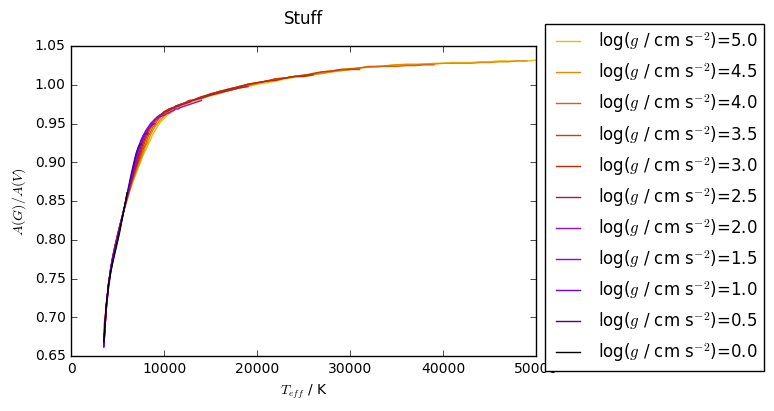

[ -2.61408749e-10   1.74301123e-05   7.64224846e-01]
[[  8.29674499e-22  -4.10549407e-17   3.21391071e-13]
 [ -4.10549407e-17   2.13247941e-12  -1.79035269e-08]
 [  3.21391071e-13  -1.79035269e-08   1.84362201e-04]]
<type 'numpy.ndarray'> (76L,)
<type 'numpy.ndarray'> (76L,)


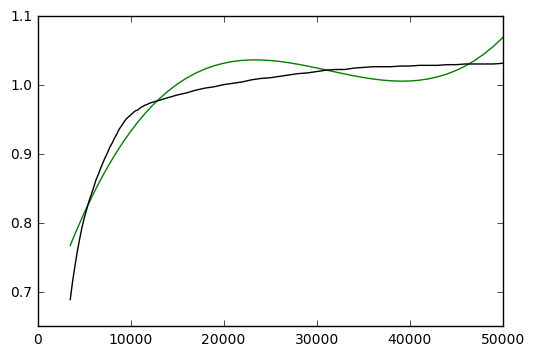

In [25]:
"""fig, gfix = plt.subplots()
# colormap stuff
nipy_spectral
plt.gca().set_color_cycle([col_map(i) for i in np.linspace(0, 0.90, len(Av0z2_logg_fix))])
"""

var_names = ['$T_{eff}$ / K','log($g$ / cm s$^{-2}$)','$A(G)/A(V)$','$A(G_{bp})/A(V)$','$A(G_{rp})/A(V)$']
fig, ax = plt.subplots()
col_map = plt.cm.gnuplot
#ax.set_xlim(0,15000)
#ax.set_ylim(-2,0)
dict_2D_plot(A_X_zs_gfix,ax,1,3,var_names,col_map)

Teff_5 = (A_X_zs_gfix['5.0'])[:,0]
A_G_5 = (A_X_zs_gfix['5.0'])[:,2]


fit0_p3 = np.polyfit(Teff_5,A_G_5,3)
#print fit0_p3

fit5_p3 = np.polyfit(Teff_5,A_G_5,3)
#print fit5_p3
fit5_p2,covout = np.polyfit(Teff_5,A_G_5,2,cov=True)
print fit5_p2
print covout
fit5_p4 = np.polyfit(Teff_5,A_G_5,4)
fit5_p5 = np.polyfit(Teff_5,A_G_5,5)
#print fit5_p4

predict5_2 = (fit5_p2[0])*Teff_5**2 + (fit5_p2[1])*Teff_5 +(fit5_p2[2])
predict5_3 = (fit5_p3[0])*Teff_5**3 + (fit5_p3[1])*Teff_5**2 + (fit5_p3[2])*Teff_5 +(fit5_p3[3])
predict5_4 = (fit5_p4[0])*Teff_5**4 + (fit5_p4[1])*Teff_5**3 + (fit5_p4[2])*Teff_5**2 + (fit5_p4[3])*Teff_5 +(fit5_p4[4])
predict5_5 = (fit5_p5[0])*Teff_5**5 + (fit5_p5[1])*Teff_5**4 + (fit5_p5[2])*Teff_5**3 + (fit5_p5[3])*Teff_5**2 + (fit5_p5[4])*Teff_5 +(fit5_p5[5])
print type(predict5_2), predict5_2.shape
print type(predict5_3), predict5_3.shape

fig,ax = plt.subplots()

#ax.plot(Teff_5,predict5_2,'r')
ax.plot(Teff_5,predict5_3,'g')
#ax.plot(Teff_5,predict5_4,'b')
#ax.plot(Teff_5,predict5_5,'m')

ax.plot(Teff_5,A_G_5,'k')
plt.show()

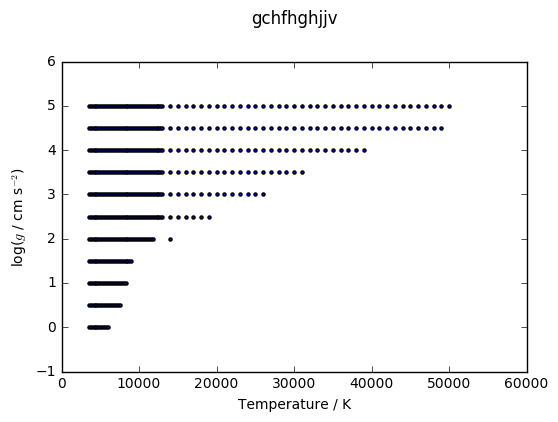

In [44]:
fig, ax = plt.subplots()
#ax.axhline(y=0.0, color='m', linestyle='--')
# Create a continuous norm to map from data points to colors | np.log10((Dthm+1).min()),np.log10((Dthm+1).max())
ax.scatter(T_Av0zs,log_g_Av0zs,marker='.')
ax.set_xlabel('Temperature / K')
ax.set_ylabel('log($g$ / cm s$^{-2}$)')
#ax.set_xlim([0.02, 0.1])
#ax.set_ylim([0, 0.1])
#plt.show()
ax.set_title('gchfhghjjv', y=1.1)
fig.savefig('gaia_spectra/gaia_graphs/hgchgftf.png', bbox_inches='tight')